In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.simplefilter('ignore')

In [7]:
plt.style.use('ggplot')

In [4]:
#2. Calculate the correlation between the price of $OCEAN and the number of messages, new users, and active individuals on the server. 
#   Provide insights from these correlations and suggest statistical methods for analysis.

In [141]:
ocean_discord = pd.read_csv('data/oceandiscord.csv')
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'].astype(str).str[:10]) #just days
ocean_discord['message_count'] = 1

ocean_price = pd.read_csv('data/OCEAN-USD_price_data.csv')
ocean_price['Date'] = pd.to_datetime(ocean_price['Date'].astype(str).str[:10])


In [142]:
ocean_discord.Date.min(), ocean_discord.Date.max()

(Timestamp('2019-08-20 00:00:00'), Timestamp('2024-02-20 00:00:00'))

In [143]:
ocean_price.Date.min(), ocean_price.Date.max()

(Timestamp('2019-05-06 00:00:00'), Timestamp('2024-02-24 00:00:00'))

In [144]:
ocean_price = ocean_price[ocean_price.Date >= '2019-08-20']
ocean_price = ocean_price[ocean_price.Date <= '2024-02-20']
ocean_price.reset_index(drop=True, inplace=True)
ocean_price.Date.min(), ocean_price.Date.max()

(Timestamp('2019-08-20 00:00:00'), Timestamp('2024-02-20 00:00:00'))

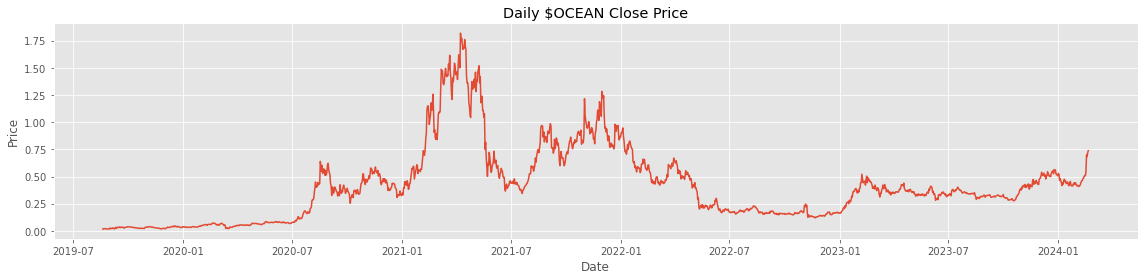

In [145]:
dates = ocean_price['Date'].to_numpy()
closing_price = ocean_price['Close'].to_numpy()

plt.figure(figsize = (16,4))
plt.plot(dates, closing_price)
plt.title('Daily $OCEAN Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [192]:
welcome_bot = 159985870458322944
welcome_channel = 'Ocean Protocol - GET STARTED - 👋︱welcome [727898674637832274]'
#ocean_discord['Is_New_User'] = (ocean_discord['AuthorID'] == welcome_bot) & (ocean_discord['Channel'] == welcome_channel)
#ocean_discord['Cumulative_New_Users'] = ocean_discord.groupby(ocean_discord['Date'].dt.date)['Is_New_User'].count()
#ocean_discord[ocean_discord['Is_New_User']==1]

In [214]:

# Identify the first message sent by each user in the welcome channel
first_messages = ocean_discord[ocean_discord['Channel'] == welcome_channel].groupby('AuthorID')['Date'].min().reset_index()
first_messages = first_messages[first_messages['AuthorID'] != welcome_bot]
first_messages.columns = ['AuthorID', 'First_Message_Date']

# Merge the first message information with the original DataFrame
users_activity = pd.merge(ocean_discord, first_messages, on='AuthorID', how='left')

# Create a binary variable to indicate whether a message is the first message sent by each user
users_activity['Is_New_User'] = ((users_activity['Channel'] == welcome_channel) & (users_activity['Date'] == users_activity['First_Message_Date']))

# Sum this variable over time to track the cumulative number of new users
# Sum this variable over time to track the cumulative number of new users
daily_new_users = users_activity.groupby(users_activity['Date'].dt.date)['Is_New_User'].sum().reset_index(name='Daily_New_Users')

In [217]:
# Define rule for active users (e.g., users who sent at least 10 messages per day)
active_users_threshold = 3
users_activity['Active_User'] = users_activity.groupby([users_activity['Date'].dt.date, 'AuthorID'])['Content'].transform('count') >= active_users_threshold

# Calculate daily active users
daily_active_users = users_activity.groupby(users_activity['Date'].dt.date)['Active_User'].sum().reset_index(name='Daily_Active_Users')


In [221]:
message_per_day = ocean_discord.groupby([pd.Grouper(key='Date', freq='D')]).size().reset_index(name='Message_Count')


In [222]:
daily_new_users['Date'] = pd.to_datetime(daily_new_users['Date'])
daily_active_users['Date'] = pd.to_datetime(daily_active_users['Date'])
message_per_day['Date'] = pd.to_datetime(message_per_day['Date'])

In [244]:

df_correlations = ocean_price[['Date', 'Close']]

df_correlations = pd.merge(df_correlations, daily_active_users,
                           on = 'Date', how = 'left')
df_correlations = pd.merge(df_correlations, daily_new_users,
                           on = 'Date', how = 'left')
df_correlations = pd.merge(df_correlations, message_per_day,
                           on = 'Date', how = 'left')

df_correlations.fillna(0, inplace=True)

In [245]:
df0 = df_correlations
df0['Close'] = df0['Close'] * 100
df0

,Date,Close,Daily_Active_Users,Daily_New_Users,Message_Count
0,2019-08-20,1.764500,0.0,0.0,3
1,2019-08-21,1.746700,0.0,0.0,2
2,2019-08-22,2.083000,0.0,0.0,16
3,2019-08-23,2.047900,0.0,0.0,1
4,2019-08-24,1.970500,0.0,0.0,1
...,...,...,...,...,...
1641,2024-02-16,53.621101,5.0,0.0,13
1642,2024-02-17,69.852799,4.0,1.0,16
1643,2024-02-18,68.288600,29.0,1.0,44
1644,2024-02-19,72.092098,26.0,0.0,51


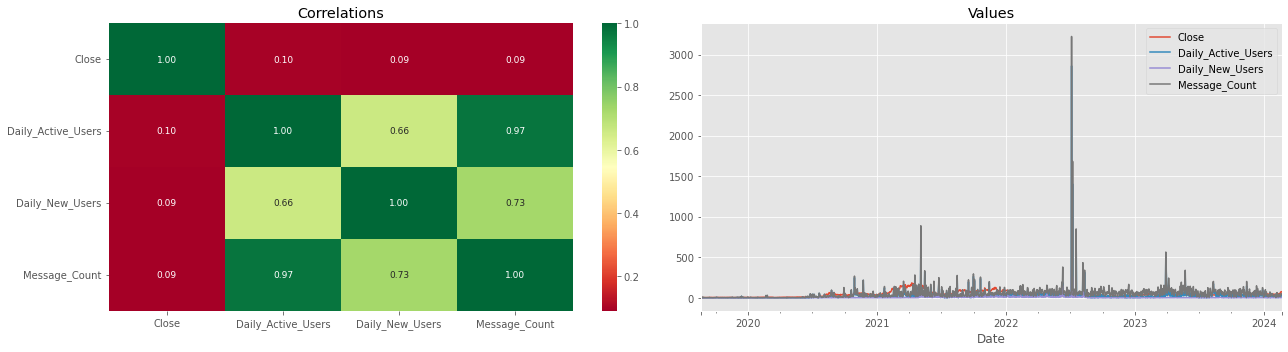

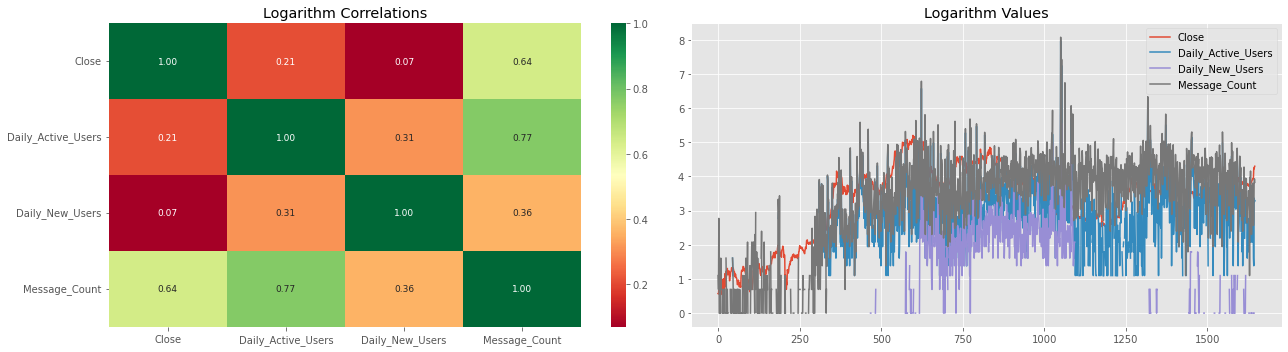

In [246]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(df0.drop(columns=['Date']).corr(), ax=axes[0], cmap='RdYlGn', annot=True, fmt='.2f', annot_kws={"size": 9})
axes[0].set_title('Correlations')
df0.plot(ax=axes[1], title='Values', x='Date')
plt.tight_layout()


# Create subplots for logarithmic values
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
# Plot correlation heatmap for logarithmic values
sns.heatmap(np.log(df0.drop(columns=['Date'])).corr(), ax=axes[0], cmap='RdYlGn', annot=True, fmt='.2f', annot_kws={"size": 9})
axes[0].set_title('Logarithm Correlations')
# Plot logarithmic values
np.log(df0.drop(columns=['Date'])).plot(ax=axes[1], title='Logarithm Values')
# Adjust layout
plt.tight_layout()
# Show plots
plt.show()

In [263]:
# Community Questions
import nltk
from nltk.tokenize import sent_tokenize

# Download necessary NLTK resources
nltk.download('punkt')

# Assuming ocean_discord is your DataFrame with the 'Content' column
ocean_discord['Is_Question'] = ocean_discord['Content'].apply(lambda x: '?' in sent_tokenize(x)[-1] if isinstance(x, str) else np.nan)

# Count the number of identified questions
question_count = ocean_discord['Is_Question'].sum()

# Print the count of identified questions
print("Total number of identified questions:", question_count)

# Example: Display some of the identified questions
print("Some examples of identified questions:")
print(ocean_discord[ocean_discord['Is_Question'] == True]['Content'].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total number of identified questions: 5539
Some examples of identified questions:
7     Anyone tried transfer dataNFT ownership to a s...
19    I saw there is WIP PR to replace web3.js with ...
22     Anyone knows where to get DAI on Mumbai testnet?
38    Hello! I was checking the latest ocean.js v3. ...
67    Hey @everyone\n\nWe just shipped a pretty awes...
Name: Content, dtype: object


In [274]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

# Assuming df contains the DataFrame with columns: Content

# Text Preprocessing
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

def preprocess_text(text):
    if pd.isna(text):  # Check if text is NaN
        return []
    tokens = word_tokenize(str(text).lower())  # Convert to string and then lowercase
    tokens = [porter.stem(token) for token in tokens if token.isalnum()]  # Stemming and remove non-alphanumeric tokens
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    return tokens

ocean_questions = ocean_discord[ocean_discord['Is_Question'] == True]
ocean_questions.reset_index(drop=True, inplace=True)

ocean_questions['Tokens'] = ocean_questions['Content'].apply(preprocess_text)

# Identify Frequently Asked Questions
all_tokens = [token for tokens in ocean_questions['Tokens'] for token in tokens]
faq_counter = Counter(all_tokens)
most_common_faq = faq_counter.most_common(20)  # Get top 20 most common words

In [285]:
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
# Example manual categorization:
technical_keywords = ['error', 'problem', 'issue', 'bug', 
                      'fix', 'testnet', 'mumbai', 'wallet',
                      'build', 'framework', 'setup', 'test', 
                      'develop', 'request', 'instal', 'repo',
                      'github', 'aw', 's3', 'bucket']
price_related_keywords = ['price', 'market', 'value', 'token',
                          'coin', 'buy', 'sell', 'trade']
general_info_keywords = ['how', 'what', 'when', 'where',
                          'why', 'ocean', 'protocol', 'ether',
                          'minter', 'data', 'marketplac', 'crypto',
                          'web3', 'earn']

# Default category for words not found in any list
default_category = 'Other'


# Function to categorize questions based on predefined keyword lists with fuzzy matching
def categorize_question(content):
    content_lower = content.lower()
    matches = {
        'Technical': process.extractOne(content_lower, technical_keywords, scorer=fuzz.token_set_ratio),
        'Price-Related': process.extractOne(content_lower, price_related_keywords, scorer=fuzz.token_set_ratio),
        'General Information': process.extractOne(content_lower, general_info_keywords, scorer=fuzz.token_set_ratio)
    }
    best_match, score = max(matches.items(), key=lambda x: x[1][1])
    score = score[1]
    if score >= 80:  # Minimum threshold for fuzzy matching score
        return best_match
    else:
        return default_category  # Assign to default category if no suitable match is found

# Apply categorization function to identify categories for questions
ocean_questions['Question_Category'] = ocean_questions[ocean_questions['Is_Question']]['Content'].apply(categorize_question)

# Count the number of questions in each category
question_category_counts = ocean_questions['Question_Category'].value_counts()

# Print the count of questions in each category
print("Question Category Counts:")
print(question_category_counts)

Question Category Counts:
Question_Category
General Information    2522
Other                  2122
Price-Related           453
Technical               442
Name: count, dtype: int64


In [ ]:
## Comunity Activity